<a href="https://colab.research.google.com/github/hanrach/marked-beetle-analysis/blob/main/grayscale_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Preprocessed grayscale images

In [1]:
import os
import glob
import shutil
import json
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator

import cv2
from sklearn.model_selection import train_test_split

In [95]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [98]:
os.chdir('/content/drive')

In [99]:
pwd

'/content/drive'

In [94]:
#os.chdir("/content/drive/MyDrive/GrayscaleThresholdBeetleImages")

In [4]:
def group_data():
  PaperedControl = glob.glob('PaperedControl*.tif')
  PaperedTransparent = glob.glob('PaperedTransparent*.tif')
  
  NoPaperedGreen = glob.glob('NoPaperedGreen*.tif')
  
  NoPaperedMixed = glob.glob('NoPaperedMixed*.tif')
  PaperedMixed = glob.glob('PaperedMixed*.tif')
  
  return PaperedControl, PaperedTransparent, NoPaperedGreen, NoPaperedMixed, PaperedMixed

def build_dataframe():
  PaperedControl, PaperedTransparent, NoPaperedGreen, NoPaperedMixed, PaperedMixed = group_data()
  marked = PaperedControl +PaperedTransparent + PaperedMixed;
  marked = [f for f in marked if "light" not in f]
  unmarked = NoPaperedGreen + NoPaperedMixed
  unmarked = [f for f in unmarked if "light" not in f]


  df = pd.DataFrame({
    "filename": marked + unmarked ,
    "category": ['Marked']*len(marked) + ['Unmarked']*len(unmarked) 
  })
  return df

In [51]:
df = build_dataframe()
df['category'] = df['category'].map({'Marked': 1, 'Unmarked': 0})

In [52]:
df.groupby('category').count()

,filename
category,
0,278
1,479


In [53]:
def visualize_batch(image_ids, labels):
    plt.figure(figsize=(16, 12))
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, ind+1 )
        image = cv2.imread(os.path.join("/content/drive/MyDrive/GrayscaleThresholdBeetleImages", image_id))
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"{label}", fontsize=12)
        plt.axis("off")
    
    plt.show()

In [54]:
def subset_train_data(image_ids):
  subset = []
  for id in image_ids:
    image = cv2.imread(os.path.join("/content/drive/MyDrive/GrayscaleThresholdBeetleImages", id))
    subset.append(image)
    return subset

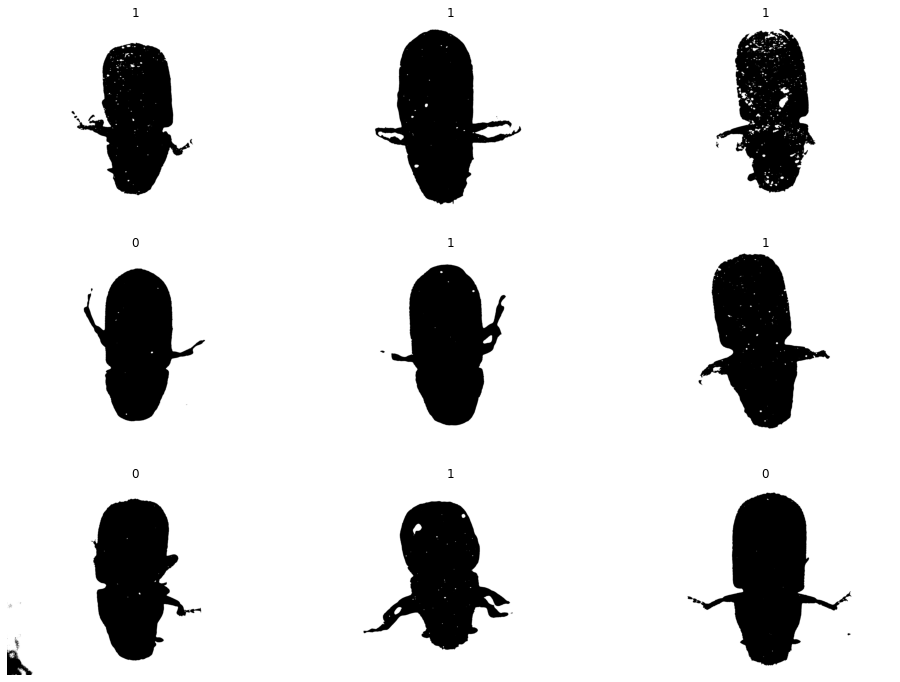

In [55]:

tmp_df = df.sample(9)

image_ids = tmp_df["filename"].values
labels = tmp_df["category"].values

visualize_batch(image_ids, labels)


# Split into train and validation

In [56]:
IMG_SIZE = 180
BATCH_SIZE = 32

In [57]:
train_df, validate_df = train_test_split(df, test_size = 0.20, random_state = 42, stratify = df['category'])
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [67]:
len(train_df)

605

In [69]:
datagen_train = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.resnet50.preprocess_input,
    featurewise_center=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
                    )

In [70]:
sample_train = train_df.sample(10);
subset_train = subset_train_data(tmp_df["filename"].values)

In [71]:
# fit the data augmentation
datagen_train.fit(subset_train)

In [72]:
datagen_val = ImageDataGenerator()

In [73]:
train_set = datagen_train.flow_from_dataframe(train_df,
                             directory = "/content/drive/MyDrive/GrayscaleThresholdBeetleImages",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = (IMG_SIZE, IMG_SIZE),
                             #color_mode="rgb",
                             class_mode = 'raw',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 605 validated image filenames.


In [74]:

validate_set = datagen_val.flow_from_dataframe(validate_df,
                             directory = "/content/drive/MyDrive/GrayscaleThresholdBeetleImages",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = (IMG_SIZE, IMG_SIZE),
                             #color_mode="rgb",
                             class_mode = 'raw',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 152 validated image filenames.


## Model (transfer learning)

In [115]:

from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import layers

def create_model():
    base_model = ResNet50(include_top=False, input_shape = (IMG_SIZE, IMG_SIZE, 3), weights="imagenet")
    base_model.trainable = False

    inputs = layers.Input(shape=(IMG_SIZE,IMG_SIZE, 3))
    x = base_model(inputs, training=False)

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
    x = layers.Flatten()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(16, bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001))(x)

    top_dropout_rate = 0.5
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    # binary classification
    outputs = layers.Dense(1,  activation = 'sigmoid', name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="ResNet50")
    return base_model, model

In [116]:
base_model, model = create_model()

In [129]:
base_model.save('/content/drive/MyDrive/base_model' + '.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [117]:
model.summary()

Model: "ResNet50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 180, 180, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 6, 6, 2048)        23587712  
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 2048)              0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_9 (Dense)              (None, 16)                32784     
_________________________________________________________________
top_dropout (Dropout)        (None, 16)                0  

In [118]:
EPOCHS=20
STEP_SIZE_TRAIN = train_set.n//train_set.batch_size
STEP_SIZE_VALID = validate_set.n//validate_set.batch_size

In [119]:
pwd

'/content/drive'

In [120]:
model.compile(optimizer=Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[keras.metrics.BinaryAccuracy()])
stop = EarlyStopping(monitor='val_loss', mode='min', patience=3,
                       restore_best_weights=True, verbose=1)
    
# Save the model with the minimum validation loss
checkpoint_cb = ModelCheckpoint("/content/drive/MyDrive/resnet_model.h5",
                                save_best_only=True,
                                monitor = 'val_loss',
                                mode='min')

# reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 2,
                              min_lr = 1e-6,
                              mode = 'min',
                              verbose = 1)
history=model.fit(train_set, epochs=20, callbacks=[stop, checkpoint_cb, reduce_lr],
                  steps_per_epoch = STEP_SIZE_TRAIN,
                  validation_steps = STEP_SIZE_VALID,
                  validation_data=validate_set)
model.save('/content/drive/MyDrive/gray_resnet50' + '.h5')

Epoch 1/20
18/18 [==============================] - 88s 5s/step - loss: 0.7770 - binary_accuracy: 0.6283 - val_loss: 1.4231 - val_binary_accuracy: 0.3672


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
18/18 [==============================] - 83s 5s/step - loss: 0.5008 - binary_accuracy: 0.7539 - val_loss: 0.6894 - val_binary_accuracy: 0.6250
Epoch 3/20
18/18 [==============================] - 84s 5s/step - loss: 0.4754 - binary_accuracy: 0.7836 - val_loss: 0.4079 - val_binary_accuracy: 0.8047
Epoch 4/20
18/18 [==============================] - 84s 5s/step - loss: 0.4794 - binary_accuracy: 0.7853 - val_loss: 0.4087 - val_binary_accuracy: 0.8359
Epoch 5/20
18/18 [==============================] - 84s 5s/step - loss: 0.4626 - binary_accuracy: 0.7661 - val_loss: 0.3658 - val_binary_accuracy: 0.8359
Epoch 6/20
18/18 [==============================] - 83s 5s/step - loss: 0.4636 - binary_accuracy: 0.7714 - val_loss: 0.4847 - val_binary_accuracy: 0.7500
Epoch 7/20
18/18 [==============================] - 83s 5s/step - loss: 0.4522 - binary_accuracy: 0.7941 - val_loss: 0.3449 - val_binary_accuracy: 0.8672
Epoch 8/20
18/18 [==============================] - 85s 5s/step - loss: 0.41

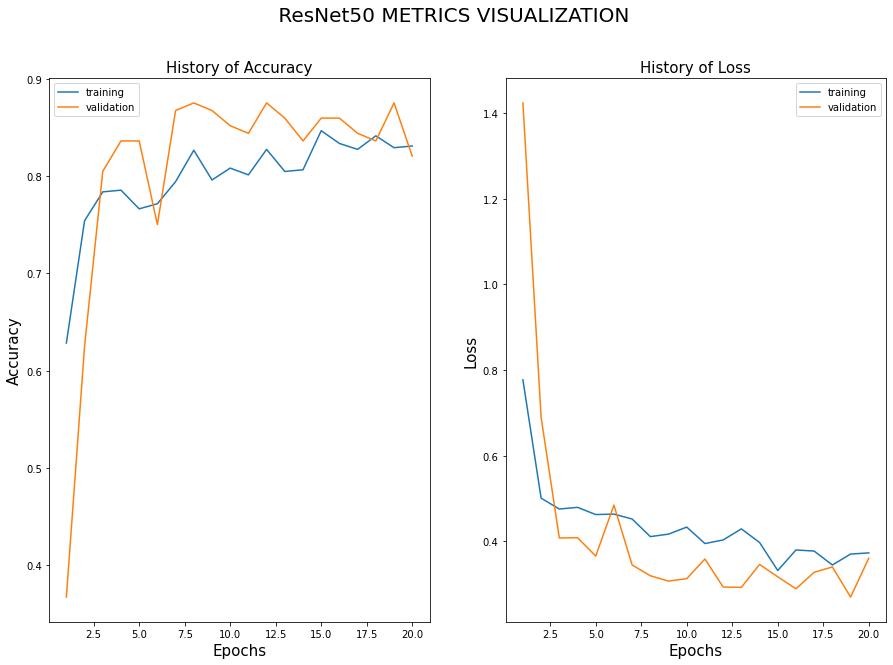

In [127]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" ResNet50 METRICS VISUALIZATION ", fontsize=20)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(history.history['binary_accuracy'],history.history['val_binary_accuracy'],
               history.history['loss'],history.history['val_loss'])

In [133]:
import keras

best_model = keras.models.load_model('/content/drive/MyDrive/resnet_model.h5')

In [131]:

# base_model.trainable = True


# model.compile(optimizer=Adam(1e-5),
#               loss=keras.losses.BinaryCrossentropy(from_logits=False),
#               metrics=[keras.metrics.BinaryAccuracy()])
# stop = EarlyStopping(monitor='val_loss', mode='min', patience=3,
#                        restore_best_weights=True, verbose=1)
    
# # Save the model with the minimum validation loss
# checkpoint_cb2 = ModelCheckpoint("/content/drive/MyDrive/resnet_model_refined.h5",
#                                 save_best_only=True,
#                                 monitor = 'val_loss',
#                                 mode='min')

# # reduce learning rate
# reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
#                               factor = 0.2,
#                               patience = 2,
#                               min_lr = 1e-6,
#                               mode = 'min',
#                               verbose = 1)

# results_finetune=model.fit(train_set, epochs=10, callbacks=[stop, checkpoint_cb2, reduce_lr],
#                   steps_per_epoch = STEP_SIZE_TRAIN,
#                   validation_steps = STEP_SIZE_VALID,
#                   validation_data=validate_set)

Epoch 1/10
18/18 [==============================] - 230s 12s/step - loss: 0.4358 - binary_accuracy: 0.8098 - val_loss: 0.3947 - val_binary_accuracy: 0.8203


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
 3/18 [====>.........................] - ETA: 2:51 - loss: 0.3974 - binary_accuracy: 0.7708

KeyboardInterrupt: ignored

In [147]:
# predict on validation set

validate_set_noshuffle = datagen_val.flow_from_dataframe(validate_df,
                             directory = "/content/drive/MyDrive/GrayscaleThresholdBeetleImages",
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = (IMG_SIZE, IMG_SIZE),

                             class_mode = 'raw',
                             shuffle = False,
                             batch_size = BATCH_SIZE)
predict=best_model.predict(validate_set_noshuffle)

Found 152 validated image filenames.


In [148]:
len(predict)

152

In [150]:
validate_df_pred = validate_df

In [151]:
validate_df_pred['prediction prob'] = predict

In [152]:
# gives probabilities: classify category `1' with probability of x 
validate_df_pred

,filename,category,prediction prob
0,NoPaperedGreen46d.tif,0,0.057907
1,PaperedTransparent16v.tif,1,0.998940
2,PaperedTransparent34v.tif,1,0.975478
3,PaperedMixed32d.tif,1,0.839283
4,NoPaperedGreen60d.tif,0,0.392937
...,...,...,...
147,NoPaperedGreen37d.tif,0,0.427680
148,PaperedTransparent38v.tif,1,0.910352
149,PaperedMixed21v.tif,1,0.990930
150,NoPaperedGreen2v.tif,0,0.473950


In [157]:
def visualize_pred(image_ids, labels, predictions ):
    plt.figure(figsize=(16, 12))
    for ind, (image_id, label, prediction) in enumerate(zip(image_ids, labels, predictions)):
        plt.subplot(3, 3, ind+1 )
        image = cv2.imread(os.path.join("/content/drive/MyDrive/GrayscaleThresholdBeetleImages", image_id))
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title("label:" + f"{label}" + " prediction:" + f"{prediction}", fontsize=12)
        plt.axis("off")
    
    plt.show()

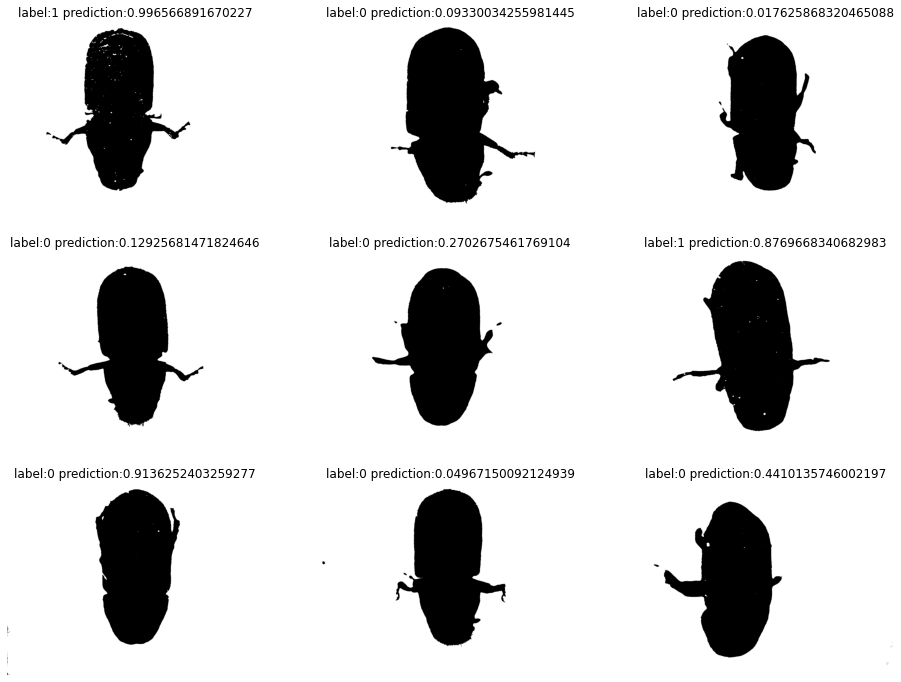

In [158]:
tmp_df = validate_df_pred.sample(9)

image_ids = tmp_df["filename"].values
labels = tmp_df["category"].values
predictions = tmp_df["prediction prob"].values

visualize_pred(image_ids, labels, predictions)

In [160]:
validate_df['prediction'] = validate_df_pred['prediction prob'].map(lambda x : 1 if x >= 0.5 else 0)

In [161]:
validate_df

,filename,category,prediction prob,prediction
0,NoPaperedGreen46d.tif,0,0.057907,0
1,PaperedTransparent16v.tif,1,0.998940,1
2,PaperedTransparent34v.tif,1,0.975478,1
3,PaperedMixed32d.tif,1,0.839283,1
4,NoPaperedGreen60d.tif,0,0.392937,0
...,...,...,...,...
147,NoPaperedGreen37d.tif,0,0.427680,0
148,PaperedTransparent38v.tif,1,0.910352,1
149,PaperedMixed21v.tif,1,0.990930,1
150,NoPaperedGreen2v.tif,0,0.473950,0


In [163]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true=list(validate_df['category'])
y_pred=list(validate_df['prediction'])
cm=confusion_matrix(y_true, y_pred, labels = [1,0])

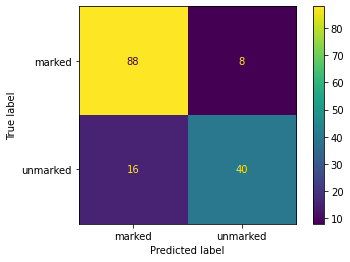

In [164]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["marked", "unmarked"])
disp.plot(values_format="d")